In [1]:
# !pip install highway-env stable-baselines3[extra] imageio tqdm --quiet

In [2]:
# pip install ipywidgets

In [3]:
# ========== SETUP ==========
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
import time
import shutil
from tqdm.notebook import tqdm
from IPython.display import clear_output, display, FileLink
import torch

from stable_baselines3 import DQN, PPO, TD3, SAC
from stable_baselines3.common.utils import set_random_seed

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [4]:
# ========== GLOBAL CONFIG ==========
SEED = 42
POLICY_TYPE = "MlpPolicy"
ROOT_FOLDER = "RLProject_MlpPolicy version3"
POLICY_FOLDER = "mlp"
OUTPUT_FOLDER = {
    "models": os.path.join(ROOT_FOLDER, POLICY_FOLDER, "models"),
    "videos": os.path.join(ROOT_FOLDER, POLICY_FOLDER, "videos"),
    "logs": os.path.join(ROOT_FOLDER, POLICY_FOLDER, "logs"),
}
set_random_seed(SEED)
for folder in OUTPUT_FOLDER.values():
    os.makedirs(folder, exist_ok=True)

In [5]:
# ========== DEVICE SETUP ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
# ========== EVALUATION ==========
def evaluate(model, env, n_episodes=5):
    rewards, collisions, episode_lengths = [], [], []
    for _ in range(n_episodes):
        obs, _ = env.reset(seed=SEED)
        done = truncated = False
        ep_reward, steps, crashed = 0, 0, False
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            ep_reward += reward
            crashed = crashed or info.get("crashed", False)
            steps += 1
        rewards.append(ep_reward)
        collisions.append(crashed)
        episode_lengths.append(steps)
    return {
        "avg_reward": np.mean(rewards),
        "collision_rate": np.mean(collisions),
        "avg_episode_length": np.mean(episode_lengths)
    }

In [7]:
# ========== RENDERING ==========
def render_episode(model, env, live=False):
    obs, _ = env.reset(seed=SEED)
    done = truncated = False
    frames = []
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        if live:
            clear_output(wait=True)
            plt.imshow(frame)
            plt.axis("off")
            display(plt.gcf())
            time.sleep(0.05)
    return frames

def render_multiple_episodes(model, env, num_episodes=3, max_steps=200):
    frames = []
    for _ in range(num_episodes):
        obs, _ = env.reset(seed=SEED)
        done = truncated = False
        steps = 0
        while not (done or truncated) and steps < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            frames.append(env.render())
            steps += 1
    return frames

def export_video(frames, filename):
    path = os.path.join(OUTPUT_FOLDER["videos"], filename)
    imageio.mimsave(path, frames, fps=15)
    print(f"Video saved to {path}")

In [8]:
# ========== TRAINING ==========
def train_agent(alg_name="DQN", total_timesteps=100000, render_every=100):
    print(f"\nTraining {alg_name} with {POLICY_TYPE}...\n")

    env_config = {
        "observation": {"type": "Kinematics"},
        "screen_width": 608,
        "screen_height": 160,
        "normalize_reward": True,
        "lanes_count": 4,
        "vehicles_count": 30,
        "duration": 40,
        "reward_speed_range": [20, 30],
        "collision_reward": -2.0,
        "right_lane_reward": 0.1,
        "high_speed_reward": 0.4,
        "lane_change_reward": 0,
    }

    if alg_name in ["TD3", "SAC"]:
        env_config["action"] = {"type": "ContinuousAction"}

    env_train = gym.make("highway-fast-v0", config=env_config)
    env_render = gym.make("highway-fast-v0", render_mode="rgb_array", config=env_config)
    env_train.reset(seed=SEED)
    env_render.reset(seed=SEED)

    shared_kwargs = {
        "policy": POLICY_TYPE,
        "env": env_train,
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "verbose": 0,
        "seed": SEED,
    }

    if POLICY_TYPE == "MlpPolicy":
        shared_kwargs["policy_kwargs"] = dict(net_arch=[512, 256])

    if alg_name == "DQN":
        model = DQN(
            **shared_kwargs,
            buffer_size=100_000,
            batch_size=64,
            learning_starts=500,
            train_freq=1,
            exploration_fraction=0.2,
            exploration_final_eps=0.05,
            target_update_interval=100,
        )
    elif alg_name == "PPO":
        model = PPO(
            **shared_kwargs,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            clip_range=0.2,
            gae_lambda=0.95,
        )
    elif alg_name == "TD3":
        model = TD3(
            **shared_kwargs,
            buffer_size=100_000,
            batch_size=64,
            learning_starts=500,
            train_freq=1,
            tau=0.005,
        )
    elif alg_name == "SAC":
        model = SAC(
            **shared_kwargs,
            buffer_size=100_000,
            batch_size=64,
            learning_starts=500,
            train_freq=1,
            tau=0.005,
        )

    steps, rewards_log, collisions_log, lengths_log = [], [], [], []
    num_episodes = total_timesteps // render_every

    for episode in tqdm(range(num_episodes), desc=f"{alg_name} Episodes"):
        model.learn(render_every, reset_num_timesteps=False)
        step = (episode + 1) * render_every
        steps.append(step)

        metrics = evaluate(model, env_render, n_episodes=3)
        rewards_log.append(metrics["avg_reward"])
        collisions_log.append(metrics["collision_rate"])
        lengths_log.append(metrics["avg_episode_length"])

        render_episode(model, env_render)

    model.save(os.path.join(OUTPUT_FOLDER["models"], f"{alg_name}_{POLICY_TYPE}"))

    frames = render_multiple_episodes(model, env_render)
    export_video(frames, f"{alg_name.lower()}_{POLICY_TYPE.lower()}.mp4")

    df = pd.DataFrame({
        "steps": steps,
        "avg_reward": rewards_log,
        "collision_rate": collisions_log,
        "episode_length": lengths_log
    })

    csv_path = os.path.join(OUTPUT_FOLDER["logs"], f"{alg_name}_{POLICY_TYPE}.csv")
    df.to_csv(csv_path, index=False)
    print(f"Logs saved to {csv_path}")

    return df

In [9]:
# ========== RUN ALL AGENTS ==========
agent_logs = {}
for alg in ["DQN", "PPO", "TD3", "SAC"]:
    agent_logs[alg] = train_agent(alg, total_timesteps=100000)


Training DQN with MlpPolicy...



DQN Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Video saved to RLProject_MlpPolicy version3\mlp\videos\dqn_mlppolicy.mp4
Logs saved to RLProject_MlpPolicy version3\mlp\logs\DQN_MlpPolicy.csv

Training PPO with MlpPolicy...



c:\Users\mkotelevskay\Desktop\RL_project\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


PPO Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Video saved to RLProject_MlpPolicy version3\mlp\videos\ppo_mlppolicy.mp4
Logs saved to RLProject_MlpPolicy version3\mlp\logs\PPO_MlpPolicy.csv

Training TD3 with MlpPolicy...



TD3 Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Video saved to RLProject_MlpPolicy version3\mlp\videos\td3_mlppolicy.mp4
Logs saved to RLProject_MlpPolicy version3\mlp\logs\TD3_MlpPolicy.csv

Training SAC with MlpPolicy...



SAC Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Video saved to RLProject_MlpPolicy version3\mlp\videos\sac_mlppolicy.mp4
Logs saved to RLProject_MlpPolicy version3\mlp\logs\SAC_MlpPolicy.csv


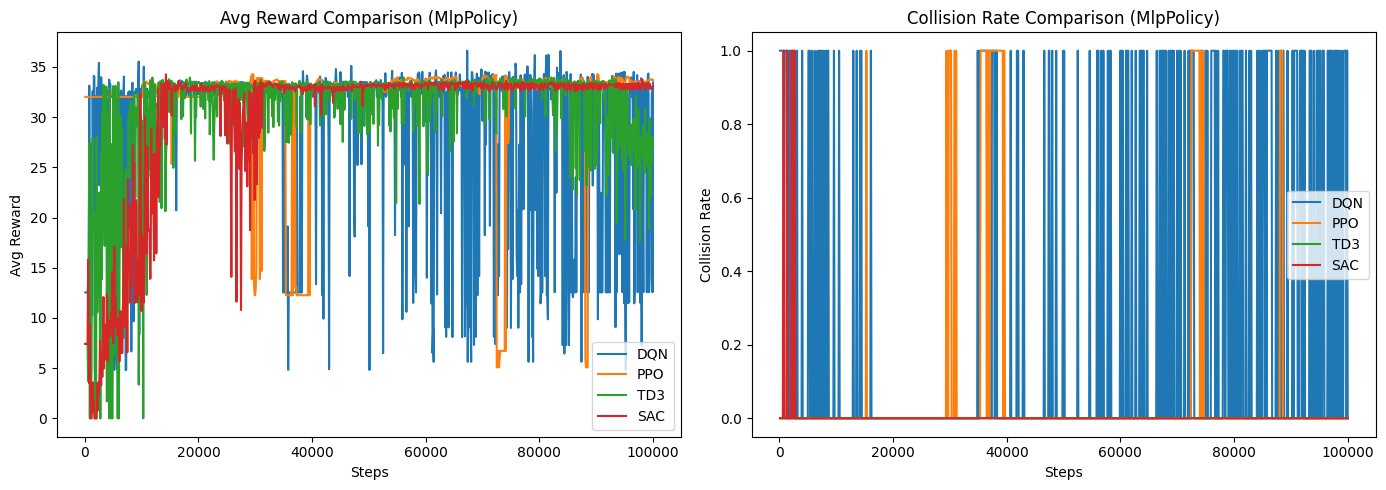

In [10]:
# ========== PLOT COMPARISONS ==========
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for alg, df in agent_logs.items():
    plt.plot(df["steps"], df["avg_reward"], label=alg)
plt.title(f"Avg Reward Comparison ({POLICY_TYPE})")
plt.xlabel("Steps")
plt.ylabel("Avg Reward")
plt.legend()

plt.subplot(1, 2, 2)
for alg, df in agent_logs.items():
    plt.plot(df["steps"], df["collision_rate"], label=alg)
plt.title(f"Collision Rate Comparison ({POLICY_TYPE})")
plt.xlabel("Steps")
plt.ylabel("Collision Rate")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# # ========== ZIP FOR DOWNLOAD ==========
# zip_filename = f"{ROOT_FOLDER}.zip"
# shutil.make_archive(ROOT_FOLDER, 'zip', ROOT_FOLDER)
# display(FileLink(zip_filename))

In [12]:
# import shutil
# import os

# ROOT_FOLDER = "RLProject_MlpPolicy version3"

# if os.path.exists(ROOT_FOLDER):
#     shutil.rmtree(ROOT_FOLDER)
#     print(f" Deleted folder: {ROOT_FOLDER}")
# else:
#     print(f"Folder '{ROOT_FOLDER}' does not exist.")
